<a href="https://colab.research.google.com/github/foryoudrizzle14/AI-/blob/main/4%EC%A3%BC%EC%B0%A8_9A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IRIS

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader, TensorDataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd


USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)


다음 기기로 학습합니다: cpu


In [ ]:


# 데이터 로드
iris = load_iris()
X, y = iris.data, iris.target

# 데이터 프레임으로 변환
df = pd.DataFrame(X, columns=iris.feature_names)
df['target'] = y

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 텐서로 변환
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)

In [ ]:
# 데이터 로더 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

클래스 > nn.Sequential로 바꾸기
or 클래스 구조 바꾸기(네트워크 바꾸기)

In [ ]:
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 50) # 입력 특성은 4개, 첫 번째 은닉층 노드는 50개
        self.fc2 = nn.Linear(50, 3) # 출력 클래스는 3개

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = IrisNet()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 학습 과정
epochs = 100
for epoch in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

In [ ]:
model.eval()  # 평가 모드로 전환
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = torch.argmax(outputs, 1)
    accuracy = (predicted == y_test_tensor).float().mean()
    print(predicted)
    print(y_test_tensor)
    print(f'Accuracy: {accuracy:.4f}')

tensor([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2,
        2, 2, 2, 2, 0, 0])
tensor([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2,
        2, 2, 2, 2, 0, 0])
Accuracy: 1.0000


## Dataset, DataLoader

In [ ]:
X_train_tensor, y_train_tensor

In [ ]:
train_dataset.__getitem__(100)

(tensor([1.0859, 0.5329, 1.1308, 1.7576]), tensor(2))

In [ ]:
class Iris_Dataset(Dataset):
  def __init__(self, data):
    super().__init__()
    self.X = data[0]
    self.y = data[1]

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]




In [ ]:
train_dataset = Iris_Dataset((X_train_tensor, y_train_tensor))

In [ ]:
train_dataset.__getitem__(1)

(tensor([-0.1331,  2.9924, -1.2760, -1.0456]), tensor(0))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)

# MNIST 오버피팅

적은양의 데이터만 사용하여 오버피팅 재현

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# MNIST 데이터셋 로드
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [ ]:
# 트레이닝 샘플 크기를 의도적으로 줄임
num_samples = 100  # 예를 들어 100개의 샘플만 사용
subset_indices = np.random.choice(len(train_data), num_samples, replace=False)
train_subset = Subset(train_data, subset_indices)

# 데이터 로더 설정
train_loader = DataLoader(train_subset, batch_size=10)
test_loader = DataLoader(test_data, batch_size=10)

In [ ]:
class DeepNet(nn.Module):
    def __init__(self):
        super(DeepNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1) # (1, 28*28)
        return self.layers(x)



In [ ]:
# 모델 초기화
model = DeepNet()

# 손실 함수 및 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# 학습 함수
def train(model, criterion, optimizer, loader):
    model.train()
    for data, target in loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# 평가 함수
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            total_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def train_test(model, criterion, optimizer, train_loader, test_loader):

  train_losses = []
  test_losses = []
  train_acces = []
  test_acces = []
  # 학습 및 평가
  for epoch in range(50):
      train(model, criterion, optimizer, train_loader)
      train_loss, train_acc = evaluate(model, train_loader)
      test_loss, test_acc = evaluate(model, test_loader)
      train_losses.append(train_loss)
      test_losses.append(test_loss)
      train_acces.append(train_acc)
      test_acces.append(test_acc)
      print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

  return train_losses, test_losses, train_acces, test_acces


In [ ]:
def plot_acc(train_acces, test_acces):
  plt.plot(train_acces, label='train_acc')
  plt.plot(test_acces, label='test_acc')
  plt.xlabel('Epoch')
  plt.ylabel('acc')
  plt.title('Training and Test acc')
  plt.legend()
  plt.show()

In [ ]:
def plot_loss(train_losses, test_losses):
  plt.plot(train_losses, label='Training Loss')
  plt.plot(test_losses, label='Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Test Loss')
  plt.legend()
  plt.show()

In [ ]:
train_losses, test_losses, train_acces, test_acces = train_test(model, criterion, optimizer, train_loader, test_loader)
plot_acc(train_acces, test_acces)
plot_loss(train_losses, test_losses)

# Overfitting 방지방법

## Regularization

In [ ]:
model = DeepNet()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5) # torch는 L2만 있음



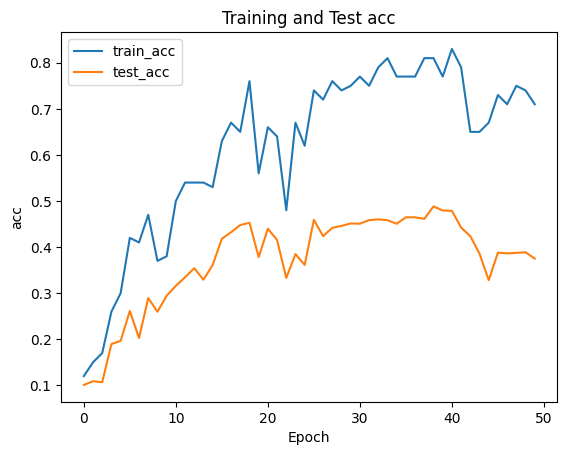

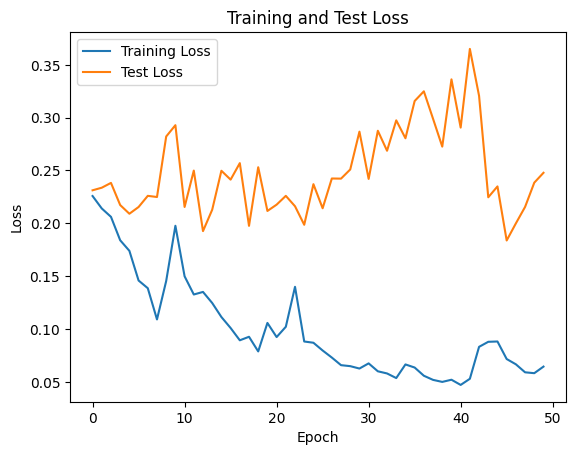

In [ ]:
train_losses, test_losses, train_acces, test_acces = train_test(model, criterion, optimizer, train_loader, test_loader)
plot_acc(train_acces, test_acces)
plot_loss(train_losses, test_losses)

## Drop-Out

In [ ]:
class DeepNet(nn.Module):
    def __init__(self):
        super(DeepNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.layers(x)



In [ ]:
model = DeepNet()
optimizer = optim.Adam(model.parameters(), lr=0.01) # torch는 L2만 있음

dropout

Epoch 1, Train Loss: 0.2258, Train Acc: 0.1900, Test Loss: 0.2345, Test Acc: 0.1158
Epoch 2, Train Loss: 0.2163, Train Acc: 0.1500, Test Loss: 0.2239, Test Acc: 0.0982
Epoch 3, Train Loss: 0.2050, Train Acc: 0.1700, Test Loss: 0.2244, Test Acc: 0.1002
Epoch 4, Train Loss: 0.2070, Train Acc: 0.2500, Test Loss: 0.2213, Test Acc: 0.2010
Epoch 5, Train Loss: 0.1973, Train Acc: 0.2600, Test Loss: 0.2210, Test Acc: 0.2139
Epoch 6, Train Loss: 0.1856, Train Acc: 0.2600, Test Loss: 0.2220, Test Acc: 0.1578
Epoch 7, Train Loss: 0.1881, Train Acc: 0.2700, Test Loss: 0.2237, Test Acc: 0.1654
Epoch 8, Train Loss: 0.2061, Train Acc: 0.2900, Test Loss: 0.2258, Test Acc: 0.1488
Epoch 9, Train Loss: 0.1835, Train Acc: 0.2800, Test Loss: 0.2211, Test Acc: 0.1731
Epoch 10, Train Loss: 0.1822, Train Acc: 0.2000, Test Loss: 0.2177, Test Acc: 0.1582
Epoch 11, Train Loss: 0.1769, Train Acc: 0.3300, Test Loss: 0.2130, Test Acc: 0.2013
Epoch 12, Train Loss: 0.1705, Train Acc: 0.2700, Test Loss: 0.2201, Test A

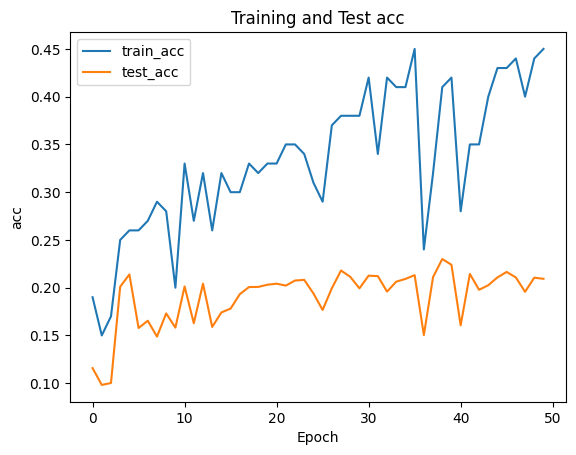

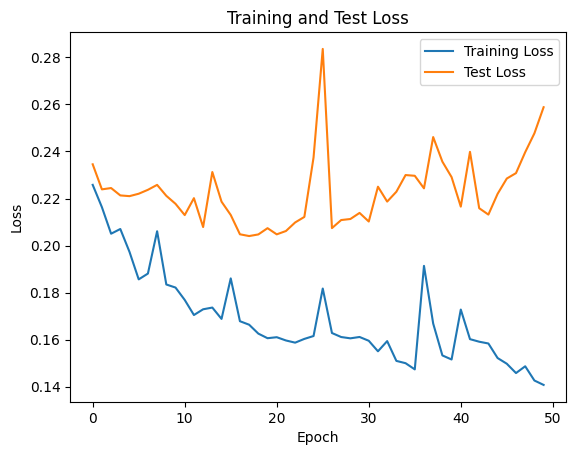

In [ ]:
train_losses, test_losses, train_acces, test_acces = train_test(model, criterion, optimizer, train_loader, test_loader)
plot_acc(train_acces, test_acces)
plot_loss(train_losses, test_losses)

## Batch Normalization

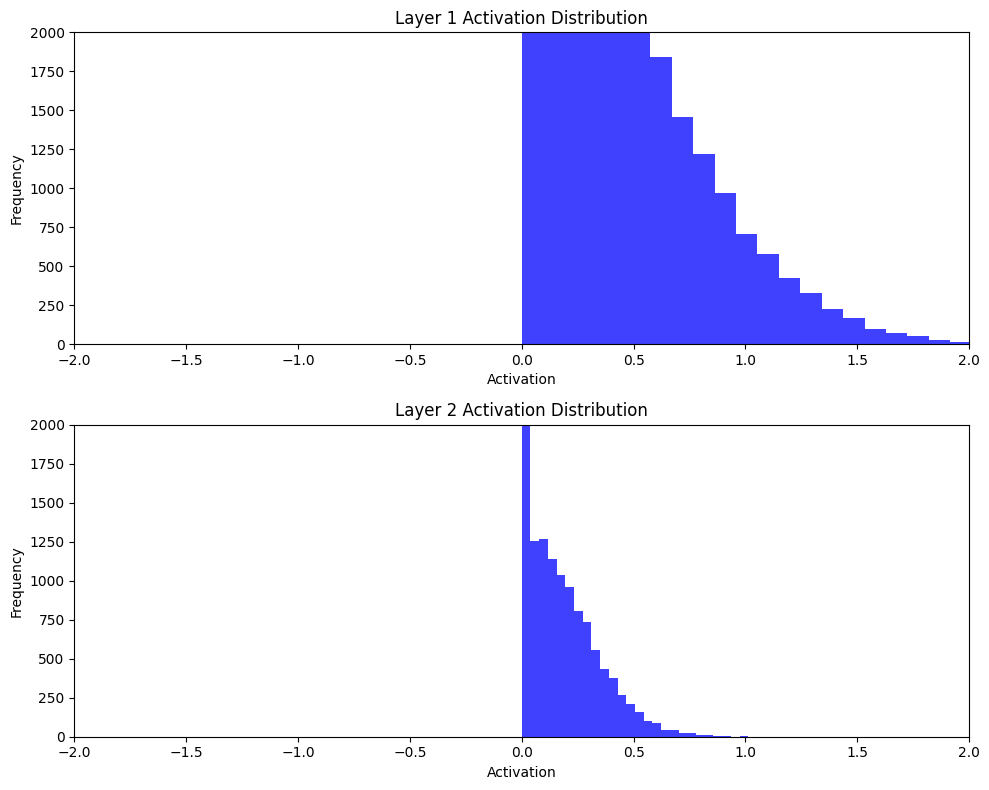

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 데이터 생성
data = torch.randn(1000, 10)  # 표준 정규 분포에서 1000개의 10차원 데이터 샘플 생성

# 간단한 신경망 정의
class SimpleNetwork(nn.Module):
    def __init__(self):
        super(SimpleNetwork, self).__init__()
        self.fc1 = nn.Linear(10, 50)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(50, 20)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        activations = []
        x = self.fc1(x)
        x = self.relu1(x)
        activations.append(x)
        x = self.fc2(x)
        x = self.relu2(x)
        activations.append(x)
        return activations

# 신경망 초기화
net = SimpleNetwork()

# 활성화 수집
activations = net(data)

# 각 레이어의 활성화 분포를 히스토그램으로 그리기
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
for i, activation in enumerate(activations):
    axes[i].hist(activation.detach().numpy().flatten(), bins=30, alpha=0.75, color='b')
    axes[i].set_title(f'Layer {i+1} Activation Distribution')
    axes[i].set_xlim([-2, 2])
    axes[i].set_ylim([0, 2000])
    axes[i].set_xlabel('Activation')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

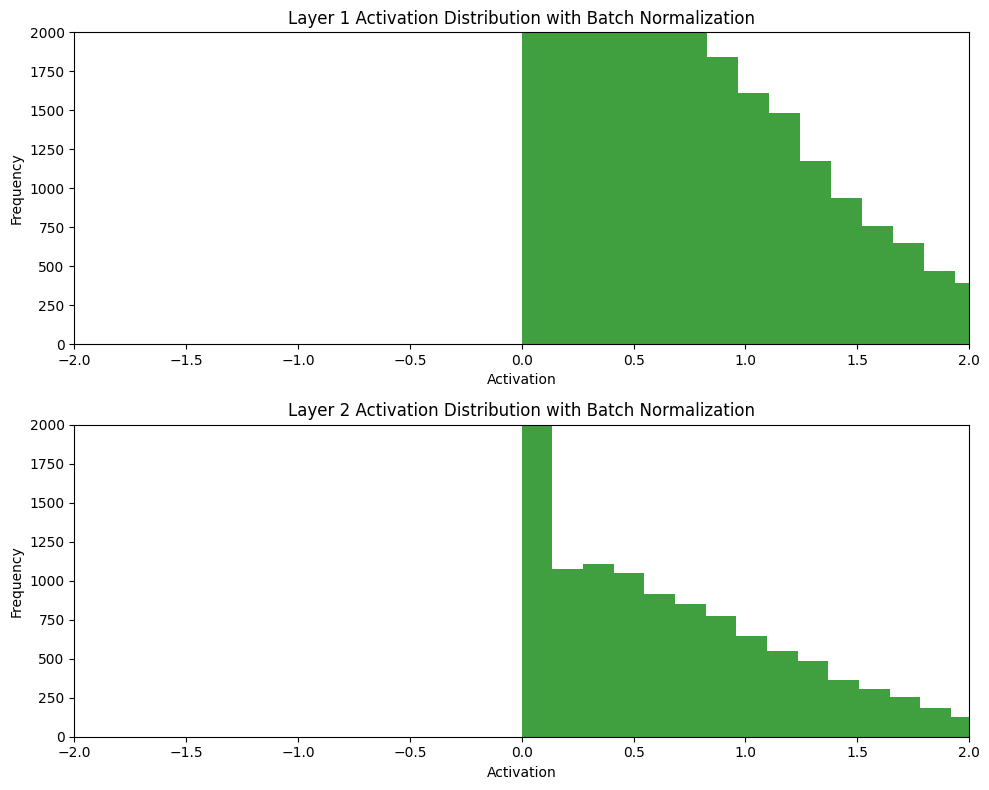

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 데이터 생성
data = torch.randn(1000, 10)  # 표준 정규 분포에서 1000개의 10차원 데이터 샘플 생성

# 간단한 신경망에 배치 노말라이제이션 적용
class NetworkWithBatchNorm(nn.Module):
    def __init__(self):
        super(NetworkWithBatchNorm, self).__init__()
        self.fc1 = nn.Linear(10, 50)
        self.bn1 = nn.BatchNorm1d(50)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(50, 20)
        self.bn2 = nn.BatchNorm1d(20)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        activations = []
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        activations.append(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        activations.append(x)
        return activations

# 신경망 초기화
net_bn = NetworkWithBatchNorm()

# 활성화 수집
activations_bn = net_bn(data)

# 각 레이어의 활성화 분포를 히스토그램으로 그리기
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
for i, activation in enumerate(activations_bn):
    axes[i].hist(activation.detach().numpy().flatten(), bins=30, alpha=0.75, color='g')
    axes[i].set_title(f'Layer {i+1} Activation Distribution with Batch Normalization')
    axes[i].set_xlim([-2, 2])
    axes[i].set_ylim([0, 2000])
    axes[i].set_xlabel('Activation')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


## Early Stopping

In [ ]:
# Early Stopping 구현
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
class DeepNet(nn.Module):
    def __init__(self):
        super(DeepNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.layers(x)

In [ ]:
def train_test(model, criterion, optimizer, train_loader, test_loader, early_stopping):

  train_losses = []
  test_losses = []
  train_acces = []
  test_acces = []
  # 학습 및 평가
  for epoch in range(50):
      train(model, criterion, optimizer, train_loader)
      train_loss, train_acc = evaluate(model, train_loader)
      test_loss, test_acc = evaluate(model, test_loader)

      train_losses.append(train_loss)
      test_losses.append(test_loss)
      train_acces.append(train_acc)
      test_acces.append(test_acc)
      print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

      early_stopping(test_loss)
      if early_stopping.early_stop:
        print('Early Stopping')
        break



  return train_losses, test_losses, train_acces, test_acces

In [ ]:
model = DeepNet()
optimizer = optim.Adam(model.parameters(), lr=0.01)

Epoch 1, Train Loss: 0.2226, Train Acc: 0.1400, Test Loss: 0.2374, Test Acc: 0.0975
Epoch 2, Train Loss: 0.2052, Train Acc: 0.2800, Test Loss: 0.2260, Test Acc: 0.1852
Epoch 3, Train Loss: 0.1674, Train Acc: 0.4300, Test Loss: 0.1977, Test Acc: 0.2550
Epoch 4, Train Loss: 0.1422, Train Acc: 0.4200, Test Loss: 0.1895, Test Acc: 0.2879
Epoch 5, Train Loss: 0.1441, Train Acc: 0.4700, Test Loss: 0.1897, Test Acc: 0.3345
Epoch 6, Train Loss: 0.1336, Train Acc: 0.4900, Test Loss: 0.1790, Test Acc: 0.3964
Epoch 7, Train Loss: 0.0961, Train Acc: 0.6400, Test Loss: 0.1735, Test Acc: 0.4559
Epoch 8, Train Loss: 0.1251, Train Acc: 0.6000, Test Loss: 0.2422, Test Acc: 0.4172
Epoch 9, Train Loss: 0.1248, Train Acc: 0.5400, Test Loss: 0.1686, Test Acc: 0.3803
Epoch 10, Train Loss: 0.1057, Train Acc: 0.6100, Test Loss: 0.2296, Test Acc: 0.4341
Epoch 11, Train Loss: 0.0922, Train Acc: 0.6700, Test Loss: 0.2333, Test Acc: 0.4222
Epoch 12, Train Loss: 0.1137, Train Acc: 0.6600, Test Loss: 0.1699, Test A

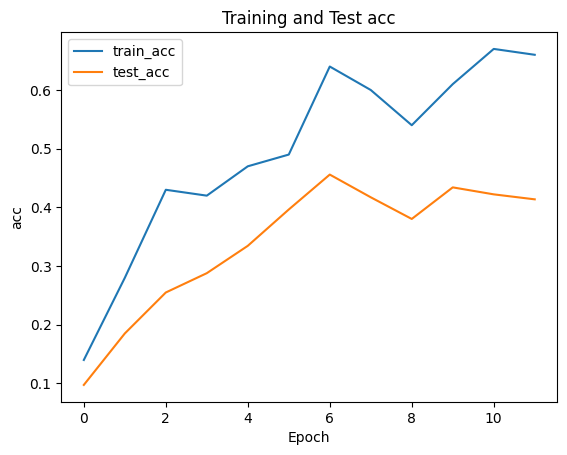

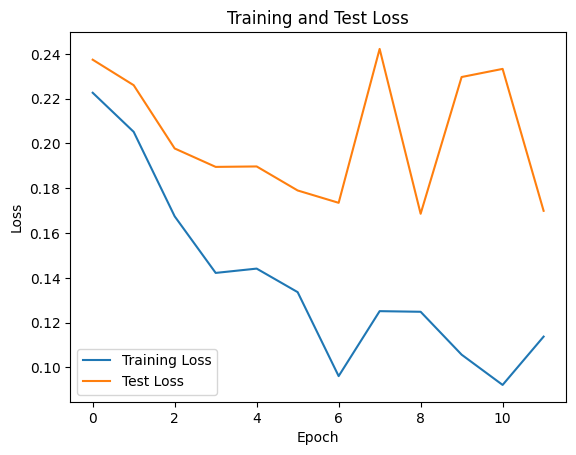

In [ ]:
early_stopping = EarlyStopping(patience=3, min_delta=0.01)
train_losses, test_losses, train_acces, test_acces = train_test(model, criterion, optimizer, train_loader, test_loader,early_stopping)
plot_acc(train_acces, test_acces)
plot_loss(train_losses, test_losses)

In [ ]:
0**4 - 4*0**3 + 4*0**2, 2**4 - 4*2**3 + 4*2**2

(0, 0)

Momentum

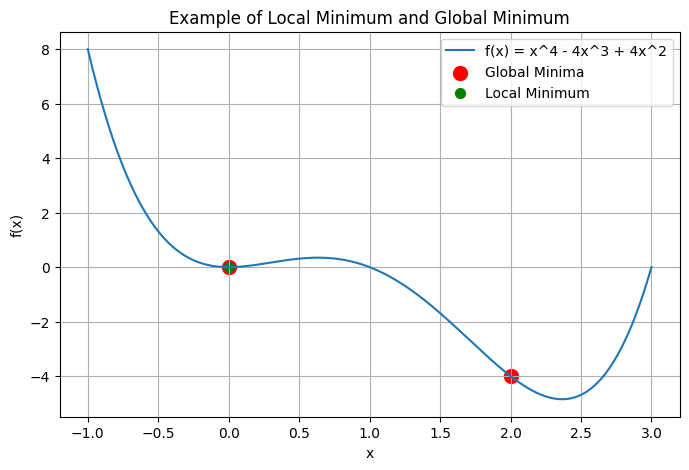

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 샘플 함수 생성: f(x) = x^4 - 4x^3 + 4x^2
x = np.linspace(-1, 3, 400)
y = x**4 - 4*x**3 + 3*x**2

# 그래프 생성
plt.figure(figsize=(8, 5))
plt.plot(x, y, label='f(x) = x^4 - 4x^3 + 4x^2')
plt.title("Example of Local Minimum and Global Minimum")
plt.xlabel("x")
plt.ylabel("f(x)")

# 극소값과 극대값 표시
minima_x = [0, 2]
minima_y = [0**4 - 4*0**3 + 4*0**2, 2**4 - 4*2**3 + 3*2**2]
plt.scatter(minima_x, minima_y, color='red', s=100, label='Global Minima')
plt.scatter([0], [minima_y[0]], color='green', s=50, label='Local Minimum')

plt.legend()
plt.grid(True)
plt.show()

# CIFAR-10


오버피팅

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
# CUDA가 사용 가능한 경우 GPU 사용, 그렇지 않으면 CPU 사용
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## CIFAR-10 데이터셋 로드와 전처리

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## 신경망 정의

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
net = Net().to(device)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# 모델 훈련
train_losses = []
val_losses = []
for epoch in range(101):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        running_loss += loss.item()

    running_loss = running_loss/len(trainloader)
    train_losses.append(running_loss)

    # 검증 오차 계산
    if epoch % 10 == 0:
      val_loss = 0.0
      with torch.no_grad():
          for data in testloader:
              images, labels = data[0].to(device), data[1].to(device)
              outputs = net(images)
              loss = criterion(outputs, labels)
              val_loss += loss.item()
      val_loss = val_loss / len(testloader)
      val_losses.append(val_loss)
      print('[epoch: %d] loss: %.3f Validation Loss: %.3f '  % (epoch + 1, running_loss, val_loss))

print('Finished Training')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[epoch: 1] loss: 2.058 Validation Loss: 1.989 


KeyboardInterrupt: 

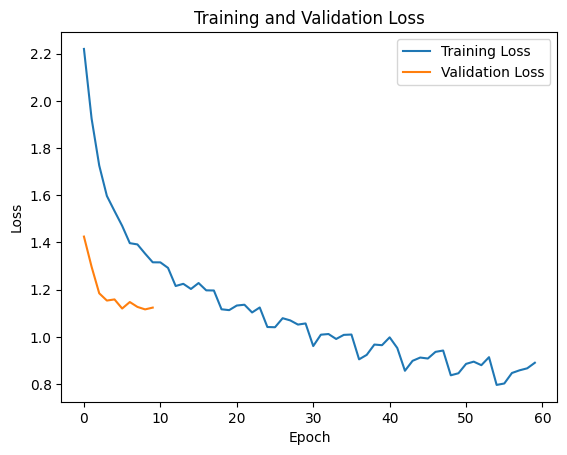

In [ ]:
# 훈련 오차와 검증 오차 그래프로 그리기
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()